In [2]:
import pandas as pd
import numpy as np
import re
from pandas import datetime
from matplotlib import pyplot as plt
import os

from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

os.chdir(r'C:\Users\Panda\Documents\MCD\curso_mcd\energyPrediction')

C:\Users\Panda\AppData\Local\Temp\ipykernel_1036\1907459888.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


### Data Frame
obtenido de: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption?select=DOM_hourly.csv


In [2]:
month_mapping = {
    'ene': 'Jan',
    'feb': 'Feb',
    'mar': 'Mar',
    'abr': 'Apr',
    'may': 'May',
    'jun': 'Jun',
    'jul': 'Jul',
    'ago': 'Aug',
    'sep': 'Sep',
    'oct': 'Oct',
    'nov': 'Nov',
    'dic': 'Dec'
}

In [3]:
carpet_path = r"C:\Users\Panda\Documents\MCD\curso_mcd\energyPrediction\cenace"
csv_files = [os.path.join(carpet_path, file) for file in os.listdir(carpet_path) if file.endswith(".csv")]

# Columnas a excluir durante la concatenación
exclude_columns = ['SISTEMA', 'AREA', 'ZONA', 'HORA', 'PRONOSTICO_MWH']

# Cargar los archivos CSV en DataFrames
dfs = []
for file in csv_files:
    with open(file, 'r') as f:
        # Leer la fila 5 y extraer la fecha
        lines = f.readlines()
        match = re.search(r'\d{2}/\w+/\d{4}', lines[10])
        date = match.group(0) if match else None
    # Cargar el archivo CSV en un DataFrame
    df = pd.read_csv(file, skiprows=7)
    
    # Agregar la columna 'Date' con la fecha extraída
    df['Date'] = date
    for month_es, month_en in month_mapping.items():
        df['Date'] = df['Date'].str.replace(month_es, month_en)
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%b/%Y').dt.strftime('%Y-%m-%d')
    
    # Excluir las columnas no deseadas si existen en el DataFrame
    columns_to_drop = [col for col in exclude_columns if col in df.columns]
    if columns_to_drop:
        df = df.drop(columns=columns_to_drop)
    dfs.append(df)

# Concatenar los DataFrames en uno solo
combined_df = pd.concat(dfs, ignore_index=True)
combined_df['Date'] = pd.to_datetime(combined_df['Date'])


In [4]:
combined_df.to_csv('combined_df.csv', index=False)

In [3]:
combined_df = pd.read_csv('combined_df.csv')

In [4]:
# promedio de energia diaria consumida por zona de carga
energy = combined_df.groupby(['Date', ' Zona de Carga'], as_index=False)[' Pronostico (MWh)'].sum()
energy['Date'] = pd.to_datetime(energy['Date'])

energy = energy.reset_index(drop=True)
energy.head()

,Date,Zona de Carga,Pronostico (MWh)
0,2019-09-01,ACAPULCO,6404.766
1,2019-09-01,AGUASCALIENTES,12094.209
2,2019-09-01,APATZINGAN,2374.062
3,2019-09-01,CABORCA,5073.123
4,2019-09-01,CAMARGO,12072.056


In [6]:
# Fecha de los datos (inicio y fin)
energy.day = pd.to_datetime(energy.Date, format='%Y-%m-%d').dt.date

print("Día de inicio de los datos",min(energy.day))
print("Día final de los datos",max(energy.day))

Día de inicio de los datos 2019-09-01
Día final de los datos 2023-06-02


# Datos Climatológicos
recuperados de: https://power.larc.nasa.gov/data-access-viewer/

In [8]:
os.chdir(r'C:\Users\Panda\Documents\MCD\curso_mcd\energyPrediction')
clima_df = pd.read_csv('clima.csv', skiprows=18)

# Convertir las columnas 'YEAR', 'MO' y 'DY' en una columna de fecha con el formato '%Y-%m-%d'
clima_df['Date'] = pd.to_datetime(clima_df[['YEAR', 'MO', 'DY']].astype(str).agg('-'.join, axis=1), format='%Y-%m-%d')

#Eliminar las primeras 3 columnas
clima_df = clima_df.drop(columns=['YEAR', 'MO', 'DY'])

clima_df.head()


,ALLSKY_SFC_UV_INDEX,WS2M,T2M_MAX,T2M_MIN,T2MDEW,T2MWET,QV2M,RH2M,PRECTOTCORR,PS,Date
0,0.29,1.32,19.51,12.54,10.71,13.11,8.06,73.88,4.45,99.83,2019-01-10
1,0.91,1.56,23.83,9.48,9.57,12.58,7.57,70.38,0.00,99.75,2019-01-11
2,0.91,1.90,23.04,9.62,5.82,10.69,5.80,54.06,0.00,99.74,2019-01-12
3,0.91,1.64,22.94,10.12,8.58,12.44,7.02,61.75,0.00,99.80,2019-01-13
4,0.72,1.28,23.80,12.22,8.65,13.00,7.02,59.25,0.00,99.87,2019-01-14


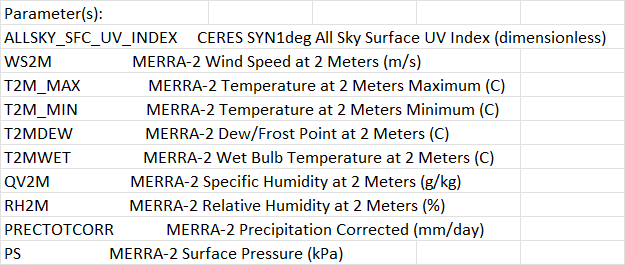

# DataFrame Energia-Clima

In [9]:
energy_city = energy.loc[energy[' Zona de Carga'] == 'HERMOSILLO'].copy()
energy_city.loc[:, 'Date'] = pd.to_datetime(energy_city['Date'])
energy_city = energy_city.reset_index(drop=True)
energy_city.tail()


C:\Users\Panda\AppData\Local\Temp\ipykernel_1036\3312237079.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  energy_city.loc[:, 'Date'] = pd.to_datetime(energy_city['Date'])


,Date,Zona de Carga,Pronostico (MWh)
1330,2023-05-29,HERMOSILLO,18152.372
1331,2023-05-30,HERMOSILLO,18065.694
1332,2023-05-31,HERMOSILLO,17591.781
1333,2023-06-01,HERMOSILLO,17086.090
1334,2023-06-02,HERMOSILLO,16674.799


In [10]:
# Merge del clima con la energía
clima_energia = energy_city.merge(clima_df, on='Date', how='inner')
clima_energia = clima_energia.reset_index(drop=True)
clima_energia.tail()


,Date,Zona de Carga,Pronostico (MWh),ALLSKY_SFC_UV_INDEX,WS2M,T2M_MAX,T2M_MIN,T2MDEW,T2MWET,QV2M,RH2M,PRECTOTCORR,PS
1330,2023-05-29,HERMOSILLO,18152.372,-999.0,2.84,36.21,18.44,10.44,18.79,8.24,42.19,0.0,99.27
1331,2023-05-30,HERMOSILLO,18065.694,-999.0,3.29,34.65,18.75,9.94,18.33,8.00,39.56,0.0,99.14
1332,2023-05-31,HERMOSILLO,17591.781,-999.0,3.12,32.50,17.32,7.00,16.01,6.53,36.00,0.0,99.00
1333,2023-06-01,HERMOSILLO,17086.090,-999.0,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.0,-999.00
1334,2023-06-02,HERMOSILLO,16674.799,-999.0,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.0,-999.00


In [11]:
clima_energia.columns

Index(['Date', ' Zona de Carga', ' Pronostico (MWh)', 'ALLSKY_SFC_UV_INDEX',
       'WS2M', 'T2M_MAX', 'T2M_MIN', 'T2MDEW', 'T2MWET', 'QV2M', 'RH2M',
       'PRECTOTCORR', 'PS'],
      dtype='object')

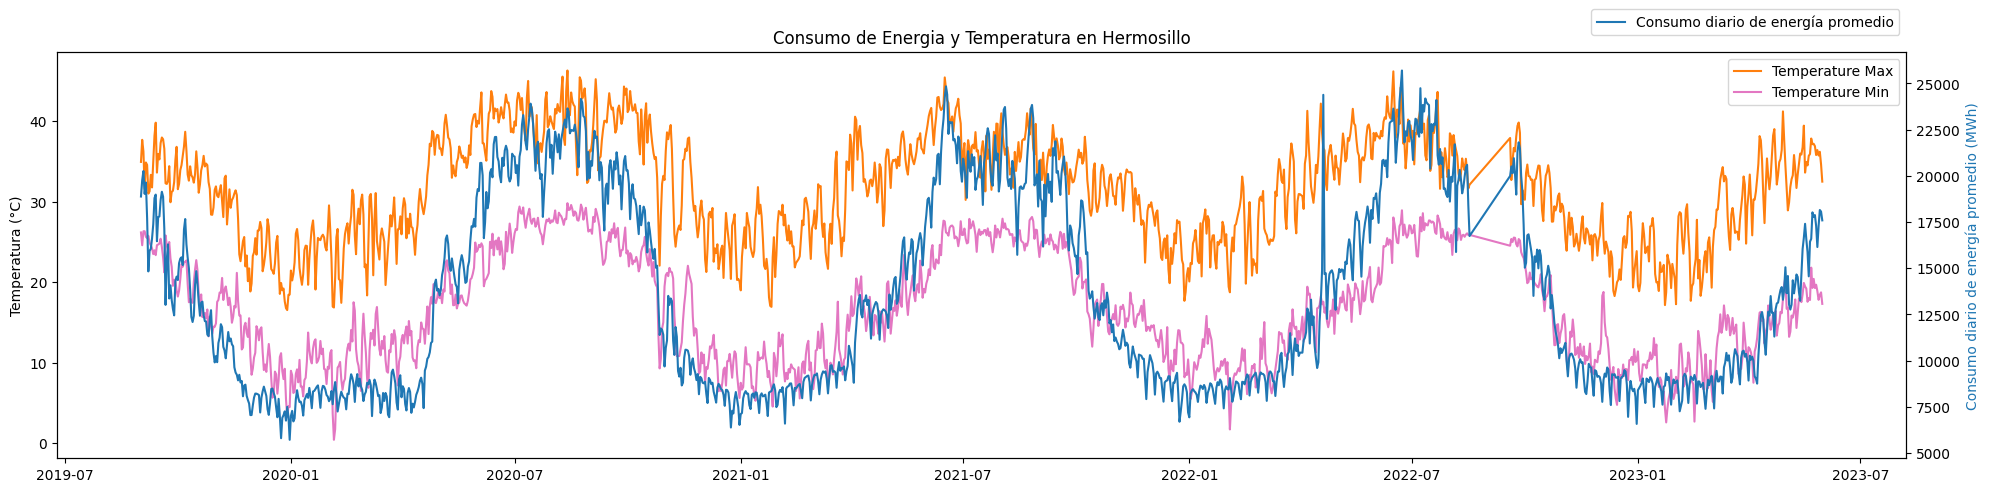

In [12]:
fig, ax1 = plt.subplots(figsize=(20, 5))
ax1.plot(clima_energia['Date'][:-2], clima_energia['T2M_MAX'][:-2], color='tab:orange', label='Temperature Max')
ax1.plot(clima_energia['Date'][:-2], clima_energia['T2M_MIN'][:-2], color='tab:pink', label='Temperature Min')
ax1.set_ylabel('Temperatura (°C)')
ax1.legend()

ax2 = ax1.twinx()
ax2.plot(clima_energia['Date'][:-2], clima_energia[' Pronostico (MWh)'][:-2], color='tab:blue', label='Consumo diario de energía promedio')
ax2.set_ylabel('Consumo diario de energía promedio (MWh)', color='tab:blue')
ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))

plt.title('Consumo de Energia y Temperatura en Hermosillo')
fig.tight_layout()
plt.show()

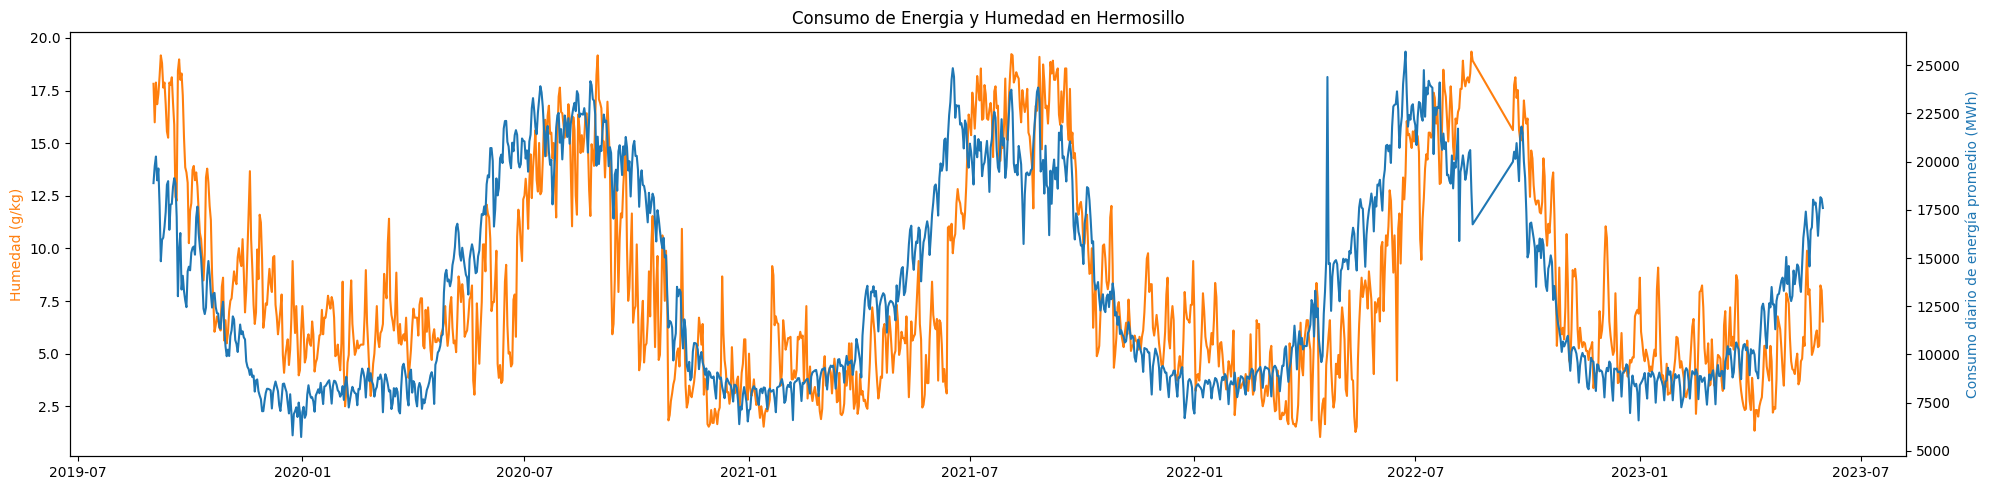

In [13]:

fig, ax1 = plt.subplots(figsize=(20, 5))
ax1.plot(clima_energia['Date'][:-2], clima_energia['QV2M'][:-2], color='tab:orange', label='Humedad')
ax1.set_ylabel('Humedad (g/kg)', color='tab:orange')

ax2 = ax1.twinx()
ax2.plot(clima_energia['Date'][:-2], clima_energia[' Pronostico (MWh)'][:-2], color='tab:blue', label='Consumo diario de energía promedio')
ax2.set_ylabel('Consumo diario de energía promedio (MWh)', color='tab:blue')

plt.title('Consumo de Energia y Humedad en Hermosillo')
fig.tight_layout()
plt.show()

In [14]:
corr = clima_energia.corr()
corr

C:\Users\Panda\AppData\Local\Temp\ipykernel_1036\4232096053.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = clima_energia.corr()


,Pronostico (MWh),ALLSKY_SFC_UV_INDEX,WS2M,T2M_MAX,T2M_MIN,T2MDEW,T2MWET,QV2M,RH2M,PRECTOTCORR,PS
Pronostico (MWh),1.000000,0.212938,-0.023839,0.109758,0.129635,0.122348,0.125199,0.060365,-0.001413,-0.011838,-0.030835
ALLSKY_SFC_UV_INDEX,0.212938,1.000000,0.090026,0.123497,0.136126,0.144283,0.137663,0.121943,0.125083,0.100893,0.090147
WS2M,-0.023839,0.090026,1.000000,0.987000,0.985595,0.975072,0.984675,0.992379,0.919747,0.992608,0.999803
T2M_MAX,0.109758,0.123497,0.987000,1.000000,0.995887,0.976495,0.991662,0.987861,0.888732,0.978780,0.985861
T2M_MIN,0.129635,0.136126,0.985595,0.995887,1.000000,0.989289,0.998145,0.994292,0.915918,0.981766,0.984830
T2MDEW,0.122348,0.144283,0.975072,0.976495,0.989289,1.000000,0.995955,0.994153,0.960416,0.976400,0.975192
T2MWET,0.125199,0.137663,0.984675,0.991662,0.998145,0.995955,1.000000,0.996906,0.935242,0.982434,0.984208
QV2M,0.060365,0.121943,0.992379,0.987861,0.994292,0.994153,0.996906,1.000000,0.946008,0.990351,0.992452
RH2M,-0.001413,0.125083,0.919747,0.888732,0.915918,0.960416,0.935242,0.946008,1.000000,0.931410,0.921955
PRECTOTCORR,-0.011838,0.100893,0.992608,0.978780,0.981766,0.976400,0.982434,0.990351,0.931410,1.000000,0.992605


# Clusters del Clima

In [15]:
scaler = MinMaxScaler(feature_range=(0, 1))
clima_escalado = scaler.fit_transform(clima_energia[['T2M_MAX', 'QV2M','WS2M']])

c:\Users\Panda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Panda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Panda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Panda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

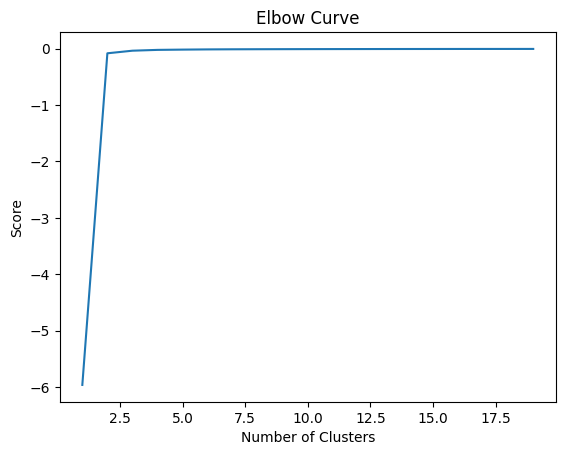

In [16]:
# k optima  
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans

score = [kmeans[i].fit(clima_escalado).score(clima_escalado) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [17]:
kmeans = KMeans(n_clusters=5, max_iter=600, algorithm = 'auto')
kmeans.fit(clima_escalado)
clima_energia['clima_cluster'] = kmeans.labels_

c:\Users\Panda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Panda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


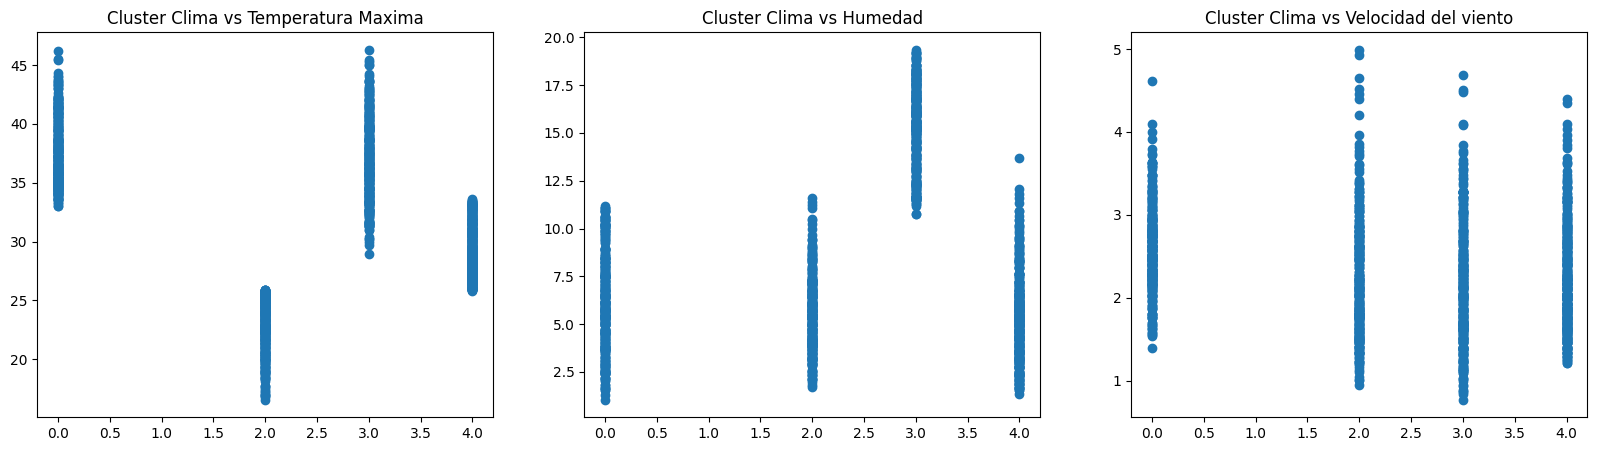

In [18]:
# Relacion de clusters con el consumo de energia
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.scatter(clima_energia.clima_cluster[:-2], clima_energia.T2M_MAX[:-2])
plt.title('Cluster Clima vs Temperatura Maxima')

plt.subplot(1, 3, 2)
plt.scatter(clima_energia.clima_cluster[:-2], clima_energia.QV2M[:-2])
plt.title('Cluster Clima vs Humedad')

plt.subplot(1, 3, 3)
plt.scatter(clima_energia.clima_cluster[:-2], clima_energia.WS2M[:-2])
plt.title('Cluster Clima vs Velocidad del viento')

plt.show()

```python
Esto te permite visualizar la relación entre los clusters de clima y diferentes variables relacionadas con el consumo de energía. Esto puede ayudar a identificar patrones o tendencias en los datos y comprender cómo el clima puede influir en el consumo de energía.
```

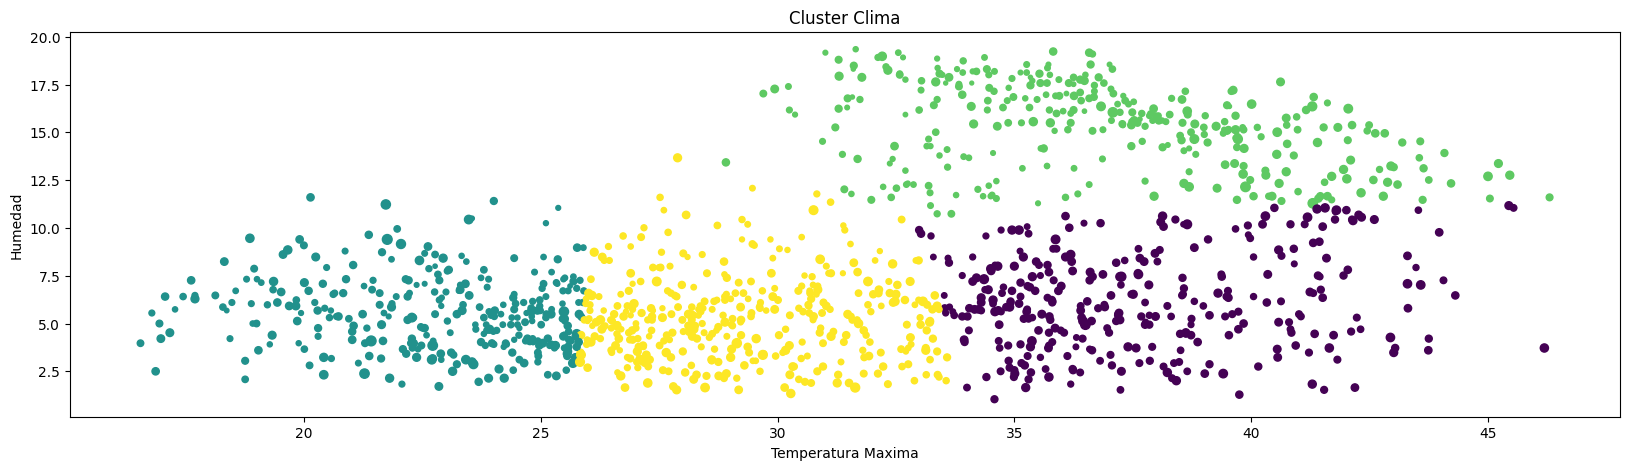

In [19]:
fig, ax1 = plt.subplots(figsize=(20, 5))
ax1.scatter(clima_energia.T2M_MAX[:-2], 
            clima_energia.QV2M[:-2],
            s=clima_energia.WS2M[:-2]*10,
            c=clima_energia.clima_cluster[:-2])
ax1.set_xlabel('Temperatura Maxima')
ax1.set_ylabel('Humedad')

plt.title('Cluster Clima')  
plt.show()

# Indicador de dias festivos


In [20]:
holiday = pd.read_csv('holidays.csv')
holiday['Fecha'] = pd.to_datetime(holiday['Fecha'], format='%d/%m/%Y')
holiday.tail()


,Fecha,Día festivo
109,2023-11-20,ía de la Revolución
110,2023-12-12,Día de la Virgen de Guadalupe
111,2023-12-24,Nochebuena
112,2023-12-25,Día de Navidad
113,2023-12-31,Noche Vieja


In [21]:
holiday['Fecha'] = pd.to_datetime(holiday['Fecha'], format='%Y-%m-%d')
clima_energia = clima_energia.merge(holiday, left_on='Date', right_on='Fecha', how='left')
clima_energia['Holiday_ind'] = np.where(clima_energia['Fecha'].isnull(), 0, 1)
clima_energia

,Date,Zona de Carga,Pronostico (MWh),ALLSKY_SFC_UV_INDEX,WS2M,T2M_MAX,T2M_MIN,T2MDEW,T2MWET,QV2M,RH2M,PRECTOTCORR,PS,clima_cluster,Fecha,Día festivo,Holiday_ind
0,2019-09-01,HERMOSILLO,18882.099,2.25,1.72,34.95,26.19,23.01,26.31,17.82,69.75,3.08,99.30,3,2019-09-01,Declaración gubernamental,1
1,2019-09-02,HERMOSILLO,19763.647,2.48,1.91,37.69,24.60,21.18,26.08,15.99,60.00,0.54,99.26,3,NaT,NaN,0
2,2019-09-03,HERMOSILLO,20260.930,2.41,1.98,36.25,26.34,23.01,26.90,17.88,65.44,5.11,99.11,3,NaT,NaN,0
3,2019-09-04,HERMOSILLO,19024.913,2.29,0.88,31.58,26.34,21.97,25.65,16.85,65.94,3.62,99.10,3,NaT,NaN,0
4,2019-09-05,HERMOSILLO,19641.506,2.19,1.33,34.88,25.65,22.55,26.26,17.33,66.12,2.84,99.37,3,NaT,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1330,2023-05-29,HERMOSILLO,18152.372,-999.00,2.84,36.21,18.44,10.44,18.79,8.24,42.19,0.00,99.27,0,NaT,NaN,0
1331,2023-05-30,HERMOSILLO,18065.694,-999.00,3.29,34.65,18.75,9.94,18.33,8.00,39.56,0.00,99.14,0,NaT,NaN,0
1332,2023-05-31,HERMOSILLO,17591.781,-999.00,3.12,32.50,17.32,7.00,16.01,6.53,36.00,0.00,99.00,4,NaT,NaN,0
1333,2023-06-01,HERMOSILLO,17086.090,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,1,NaT,NaN,0


# ARIMAX

In [22]:
clima_energia['Año']= pd.DatetimeIndex(clima_energia['Date']).year
clima_energia['Mes']= pd.DatetimeIndex(clima_energia['Date']).month
clima_energia.set_index(['Date'], inplace=True)

In [23]:
model_data = clima_energia[['Holiday_ind', ' Pronostico (MWh)','clima_cluster']]
train = model_data.iloc[0:(len(model_data)-30)]
test = model_data.iloc[len(train):(len(model_data)-1)]

,Holiday_ind,Pronostico (MWh),clima_cluster
Date,,,
2023-05-04,0,13021.986,4
2023-05-05,1,12766.219,4
2023-05-06,0,13030.178,4


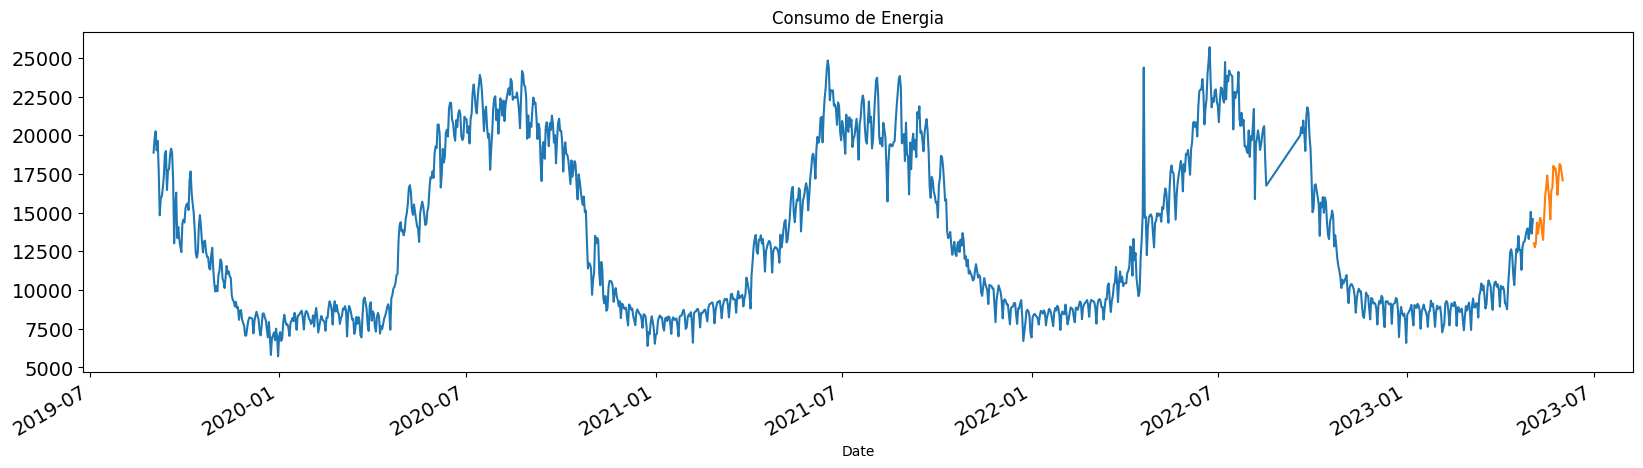

In [24]:
train[' Pronostico (MWh)'].plot(figsize=(20,5), title= 'Consumo de Energia', fontsize=14)
test[' Pronostico (MWh)'].plot(figsize=(20,5), title= 'Consumo de Energia', fontsize=14)
test.head(3)

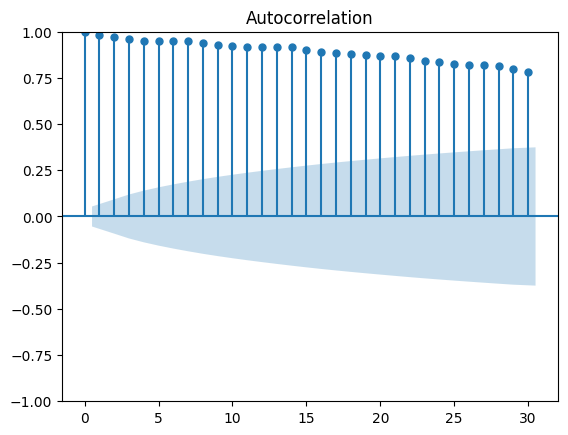

In [25]:
plot_acf(train[' Pronostico (MWh)'], lags=30)
plt.show()

```python 
 traza la función de autocorrelación (ACF) de una serie temporal. La función de autocorrelación se utiliza para analizar la autocorrelación de una serie temporal con respecto a sus valores pasados.
```

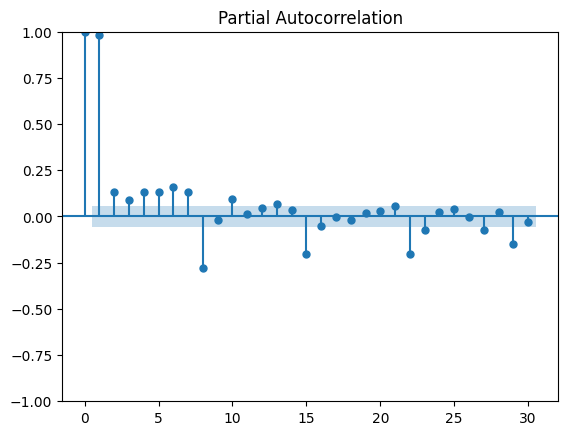

In [26]:
plot_pacf(train[' Pronostico (MWh)'], lags=30)
plt.show()

```python
trazar la función de autocorrelación parcial (PACF) de una serie temporal. La PACF es una medida de la correlación parcial entre una observación en una serie temporal y sus valores rezagados, teniendo en cuenta la influencia de los rezagos intermedios.
```

# Dickey Fuller's Test

```python
El test de Dickey-Fuller (Dickey-Fuller Test) es una prueba estadística utilizada para determinar si una serie temporal tiene una raíz unitaria, es decir, si muestra un patrón de comportamiento aleatorio o si tiene una tendencia determinística.

* p is greater than 0.05 therefore the data is not stationary. After differencing, p < 0.05.
```

In [27]:
t = sm.tsa.adfuller(train[' Pronostico (MWh)'], autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                   -2.514912
p-value                           0.111888
#Lags Used                       22.000000
Number of Observations Used    1282.000000
dtype: float64

In [28]:
def difference(dataset, interval):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset.iloc[i] - dataset.iloc[i - interval]
        diff.append(value)
    return diff

In [29]:
t = sm.tsa.adfuller(difference(train[' Pronostico (MWh)'], 1), autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                -5.978729e+00
p-value                        1.860422e-07
#Lags Used                     2.100000e+01
Number of Observations Used    1.282000e+03
dtype: float64

# Seasonal Decomposition

<AxesSubplot: title={'center': 'Seasonality'}, xlabel='Date'>

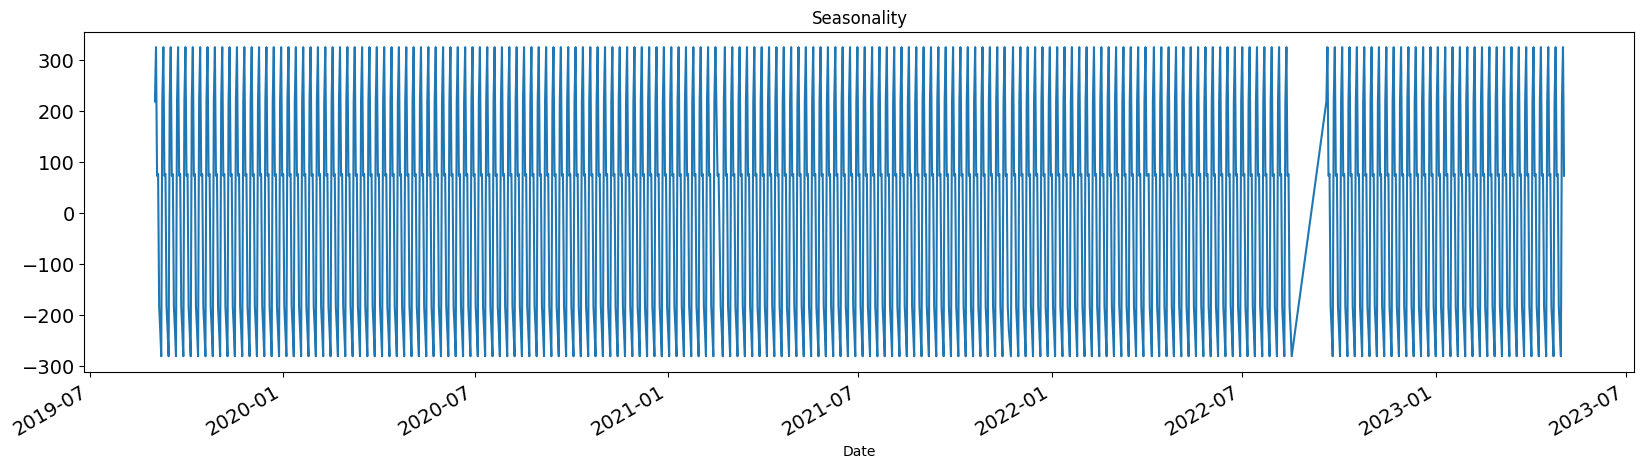

In [30]:
s = sm.tsa.seasonal_decompose(train[' Pronostico (MWh)'], period=7)
s.seasonal.plot(figsize=(20,5), title= 'Seasonality', fontsize=14)

<AxesSubplot: title={'center': 'Trend'}, xlabel='Date'>

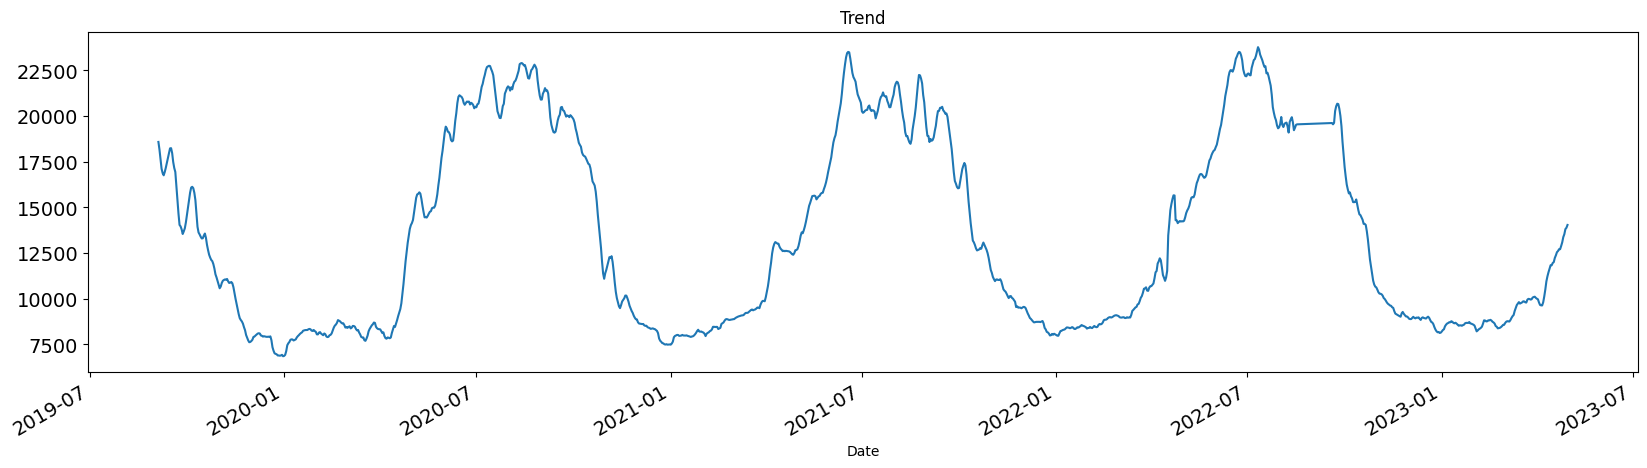

In [31]:
s.trend.plot(figsize=(20,5), title= 'Trend', fontsize=14)


<AxesSubplot: title={'center': 'Residual'}, xlabel='Date'>

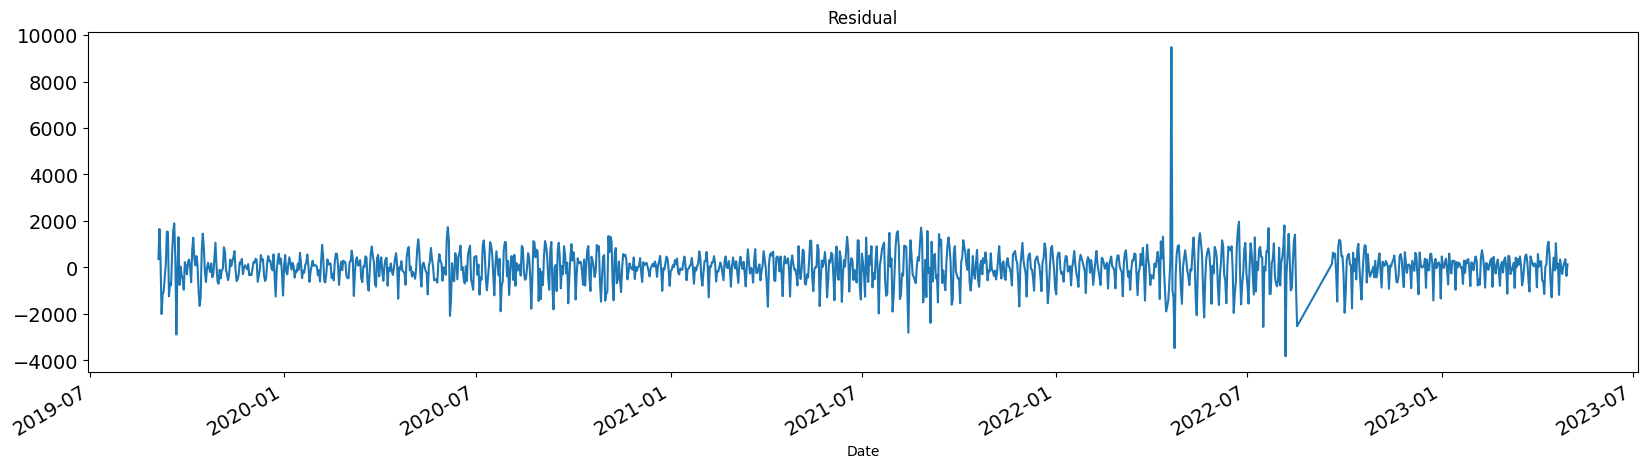

In [32]:
s.resid.plot(figsize=(20,5), title= 'Residual', fontsize=14)

In [33]:
endog = train[' Pronostico (MWh)']
exog = train[['Holiday_ind', 'clima_cluster']]
mod = sm.tsa.statespace.SARIMAX(endog=endog, exog=exog, order=(1,1,1), seasonal_order=(1,1,1,7), enforce_stationarity=False, enforce_invertibility=False)
model_fit = mod.fit()
print(model_fit.summary())

c:\Users\Panda\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Panda\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                  Pronostico (MWh)   No. Observations:                 1305
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -10497.122
Date:                           Wed, 07 Jun 2023   AIC                          21008.245
Time:                                   09:35:20   BIC                          21044.371
Sample:                                        0   HQIC                         21021.806
                                          - 1305                                         
Covariance Type:                             opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Holiday_ind    -100.6211     93.908     -1.071      0.284    -284.677      83.435
clima_cluster   -13.8017     23.25

# Model Fit

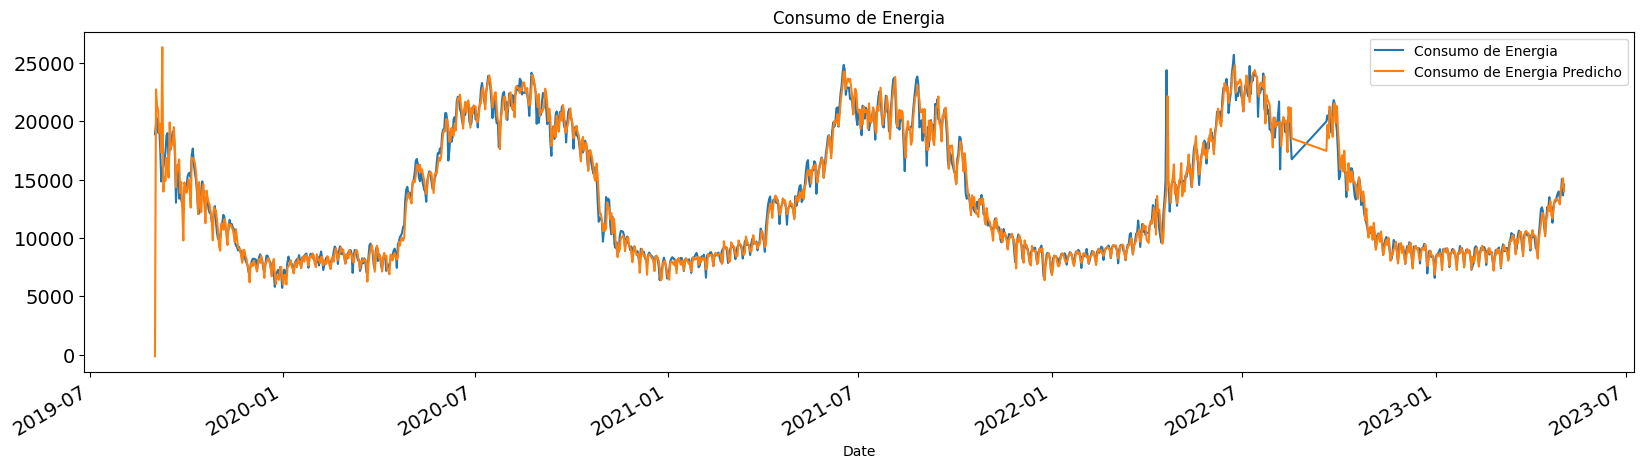

In [34]:
train[' Pronostico (MWh)'].plot(figsize=(20,5), title= 'Consumo de Energia', fontsize=14)
model_fit.fittedvalues.plot(figsize=(20,5), title= 'Consumo de Energia', fontsize=14)
plt.legend(['Consumo de Energia', 'Consumo de Energia Predicho'])
plt.show()

# Predicción

In [35]:
predict = model_fit.predict(start=len(train), end=len(train)+len(test)-1, exog=test[['Holiday_ind', 'clima_cluster']])
test['predicted'] = predict.values
test.head(3)

c:\Users\Panda\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Panda\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\Panda\AppData\Local\Temp\ipykernel_1036\1930914348.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted'] = predict.values


,Holiday_ind,Pronostico (MWh),clima_cluster,predicted
Date,,,,
2023-05-04,0,13021.986,4,14388.597889
2023-05-05,1,12766.219,4,13911.741166
2023-05-06,0,13030.178,4,13169.110435


In [36]:
test['residual'] = abs(test[' Pronostico (MWh)'] - test['predicted'])
MAE = test['residual'].sum()/len(test)
MAPE = (test['residual']/test[' Pronostico (MWh)']).sum()*100/len(test)
print('MAE: ', MAE)
print('MAPE: ', MAPE)

MAE:  860.1994094369037
MAPE:  5.399178065436938


C:\Users\Panda\AppData\Local\Temp\ipykernel_1036\2578446003.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['residual'] = abs(test[' Pronostico (MWh)'] - test['predicted'])


* MAE (Mean Absolute Error):
El MAE es una medida de error absoluto promedio. Calcula la diferencia absoluta promedio entre las predicciones del modelo y los valores reales.

* MAPE (Mean Absolute Percentage Error):
El MAPE es una medida de error porcentual promedio. Calcula el porcentaje promedio de diferencia absoluta entre las predicciones del modelo y los valores reales en relación con los valores reales.

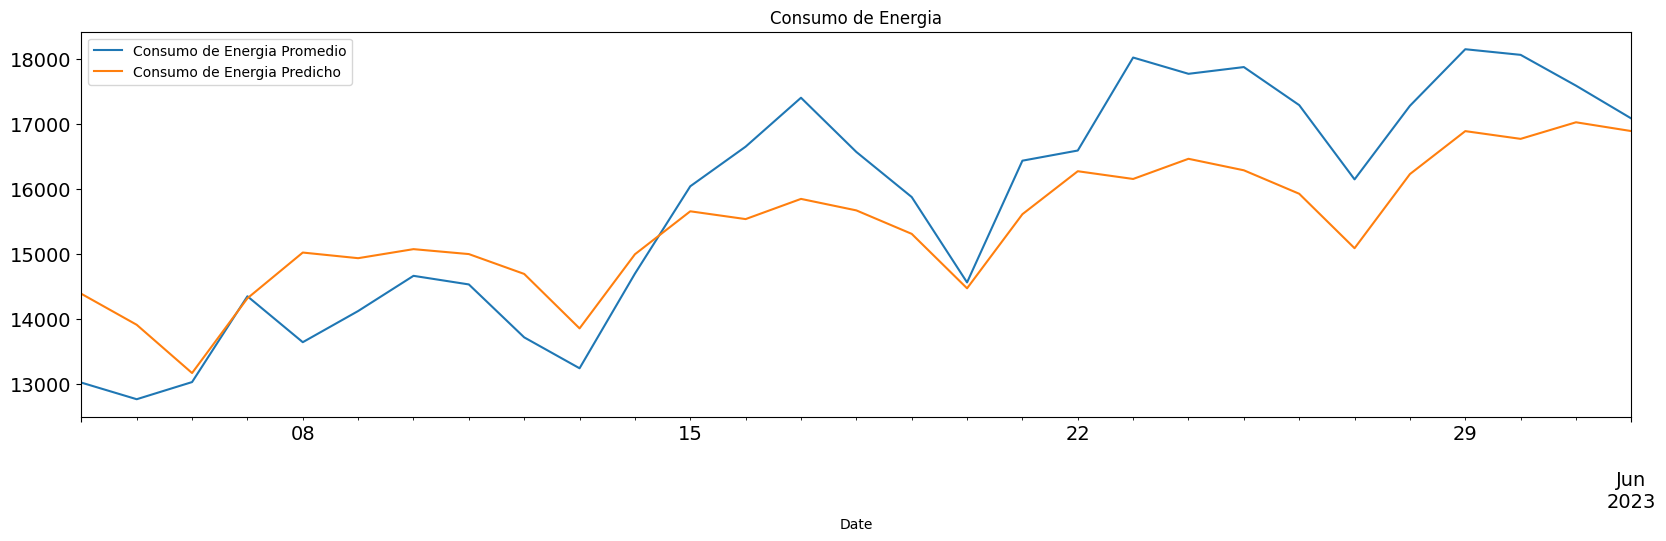

In [37]:
test[' Pronostico (MWh)'].plot(figsize=(20,5), title= 'Consumo de Energia', fontsize=14)
test['predicted'].plot(figsize=(20,5), title= 'Consumo de Energia', fontsize=14)
plt.legend(['Consumo de Energia Promedio', 'Consumo de Energia Predicho'])
plt.show()

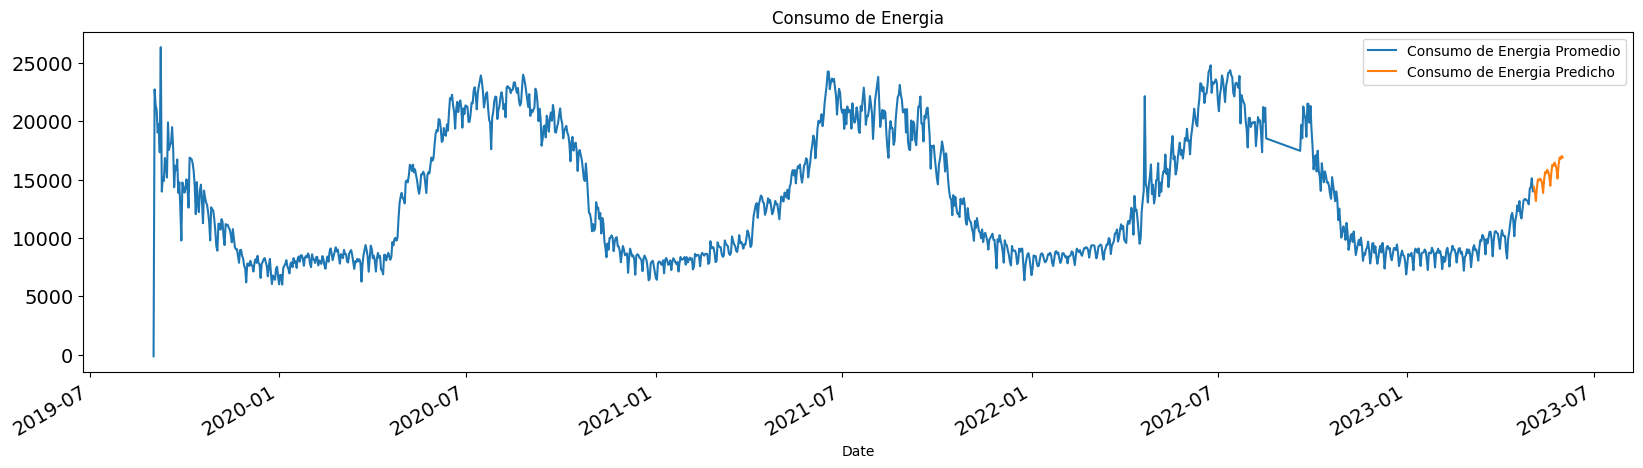

In [40]:
model_fit.fittedvalues.plot(figsize=(20,5), title= 'Consumo de Energia', fontsize=14)
test['predicted'].plot(figsize=(20,5), title= 'Consumo de Energia', fontsize=14)
plt.legend(['Consumo de Energia Promedio', 'Consumo de Energia Predicho'])


# LSTM

In [43]:
np.random.seed(11)
df = clima_energia.loc[:, [' Pronostico (MWh)']]
dataset = df.values
dataset = dataset.astype('float32')

In [44]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [47]:
reframed = series_to_supervised(dataset, 7, 1)
reframed.head(3)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,18882.099609,19763.646484,20260.929688,19024.912109,19641.505859,17709.292969,14831.011719,15941.323242
8,19763.646484,20260.929688,19024.912109,19641.505859,17709.292969,14831.011719,15941.323242,16053.044922
9,20260.929688,19024.912109,19641.505859,17709.292969,14831.011719,15941.323242,16053.044922,16605.509766


In [46]:
reframed['clima_cluster'] = clima_energia['clima_cluster'].values[7:]
reframed['Holiday_ind'] = clima_energia['Holiday_ind'].values[7:]


In [48]:
reframed = reframed.reindex(columns=['var1(t-7)', 'var1(t-6)', 'var1(t-5)', 'var1(t-4)', 'var1(t-3)', 'var1(t-2)', 'var1(t-1)', 'clima_cluster', 'Holiday_ind', 'var1(t)'])
reframed = reframed.values

# Normalization

In [65]:

scaler = MinMaxScaler(feature_range=(0, 1))
reframed = scaler.fit_transform(reframed)

# split into train and test sets
train = reframed[:int(len(reframed)*0.8), :]
test = reframed[int(len(reframed)*0.8):, :]

c:\Users\Panda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
c:\Users\Panda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [69]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Imputar valores faltantes utilizando la media
imputer = SimpleImputer(strategy='mean')
reframed_imputed = imputer.fit_transform(reframed)

# Escalar características en el rango de 0 a 1
scaler = MinMaxScaler(feature_range=(0, 1))
reframed_scaled = scaler.fit_transform(reframed_imputed)

# Dividir en conjuntos de entrenamiento y prueba
train = reframed_scaled[:int(len(reframed_scaled) * 0.8), :]
test = reframed_scaled[int(len(reframed_scaled) * 0.8):, :]


In [70]:
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [71]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1062, 1, 7) (1062,) (266, 1, 7) (266,)


# Modelling

Epoch 1/50
15/15 - 4s - loss: 0.2893 - val_loss: 0.1378 - 4s/epoch - 278ms/step
Epoch 2/50
15/15 - 0s - loss: 0.1415 - val_loss: 0.0565 - 96ms/epoch - 6ms/step
Epoch 3/50
15/15 - 0s - loss: 0.0707 - val_loss: 0.0695 - 93ms/epoch - 6ms/step
Epoch 4/50
15/15 - 0s - loss: 0.0664 - val_loss: 0.0516 - 88ms/epoch - 6ms/step
Epoch 5/50
15/15 - 0s - loss: 0.0565 - val_loss: 0.0415 - 88ms/epoch - 6ms/step
Epoch 6/50
15/15 - 0s - loss: 0.0489 - val_loss: 0.0368 - 87ms/epoch - 6ms/step
Epoch 7/50
15/15 - 0s - loss: 0.0449 - val_loss: 0.0349 - 91ms/epoch - 6ms/step
Epoch 8/50
15/15 - 0s - loss: 0.0435 - val_loss: 0.0345 - 95ms/epoch - 6ms/step
Epoch 9/50
15/15 - 0s - loss: 0.0431 - val_loss: 0.0344 - 91ms/epoch - 6ms/step
Epoch 10/50
15/15 - 0s - loss: 0.0429 - val_loss: 0.0343 - 92ms/epoch - 6ms/step
Epoch 11/50
15/15 - 0s - loss: 0.0426 - val_loss: 0.0341 - 92ms/epoch - 6ms/step
Epoch 12/50
15/15 - 0s - loss: 0.0424 - val_loss: 0.0340 - 89ms/epoch - 6ms/step
Epoch 13/50
15/15 - 0s - loss: 0.0422

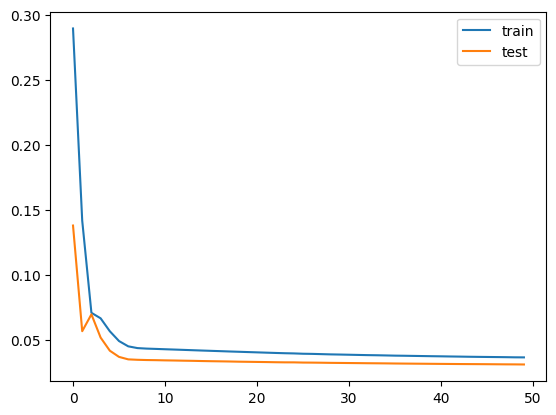

In [73]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


# Prediction

In [74]:
# hacer una prediccion
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invertir la escala para la prediccion
inv_yhat = np.concatenate((yhat, test_X), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)

# invertir la escala para los valores reales
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)

9/9 [==============================] - 1s 2ms/step


# Performance

In [85]:
act = [i[-1] for i in inv_y] # last element is the predicted average energy
pred = [i[-1] for i in inv_yhat] # last element is the actual average energy

# calculate RMSE
rmse = math.sqrt(mean_squared_error(act, pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.000


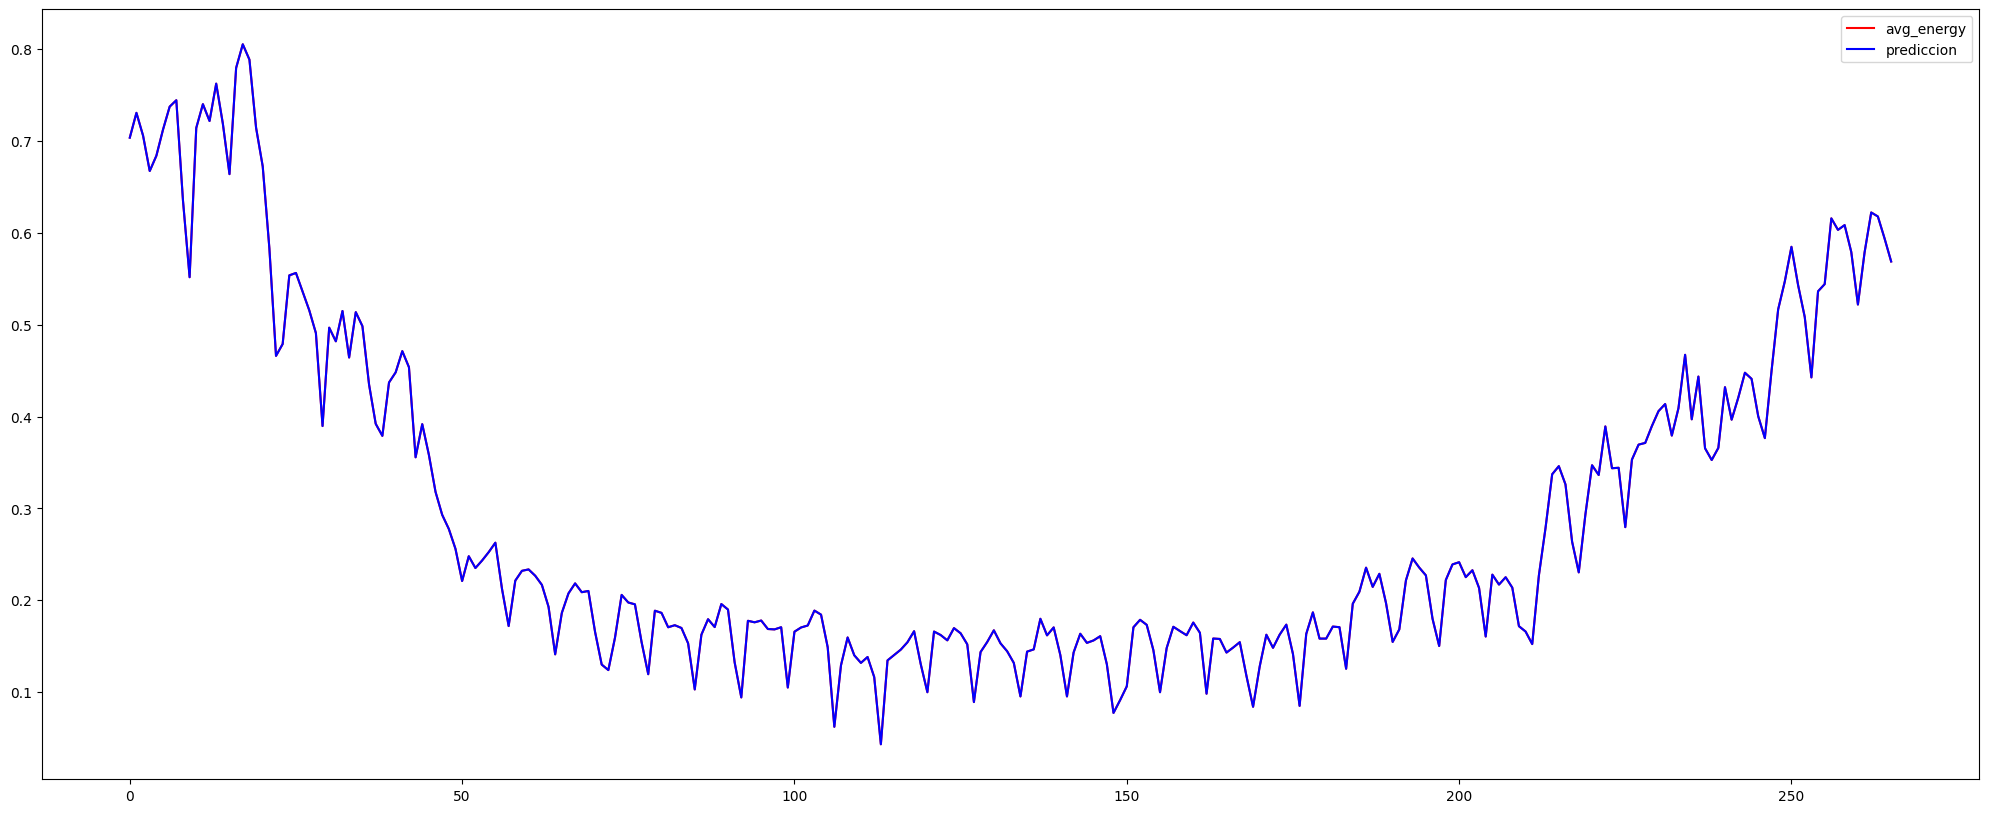

In [87]:
predicted_lstm = pd.DataFrame({'prediccion':pred,'avg_energy':act})
predicted_lstm['avg_energy'].plot(figsize=(25,10),color = 'red')
predicted_lstm['prediccion'].plot(color = 'blue')
plt.legend(loc='best')
plt.show()

## Referencias
https://www.kaggle.com/code/rheajgurung/energy-consumption-forecast

https://www.youtube.com/watch?v=QcP3tU3uMYo&t=3594s